In [1]:
import os
import pandas as pd
import warnings
import numpy as np
from sklearn.preprocessing import LabelEncoder
import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

warnings.filterwarnings("ignore")

# Скачивание данных

In [2]:
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json
!echo '{"username":"tommmatojuice","key":"310feab09dc6cd648200c6d91c88ce14"}' > /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d arashnic/book-recommendation-dataset

 38% 9.00M/23.8M [00:00<00:00, 37.0MB/s]
100% 23.8M/23.8M [00:00<00:00, 81.1MB/s]


In [4]:
!unzip -q book-recommendation-dataset.zip

In [5]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv")
users = pd.read_csv("Users.csv")

display(books.head(3))
display(ratings.head(3))
display(users.head(3))

ISBN            Book-Title           Book-Author Year-Of-Publication  \
0  0195153448   Classical Mythology    Mark P. O. Morford                2002   
1  0002005018          Clara Callan  Richard Bruce Wright                2001   
2  0060973129  Decision in Normandy          Carlo D'Este                1991   

                 Publisher                                        Image-URL-S  \
0  Oxford University Press  http://images.amazon.com/images/P/0195153448.0...   
1    HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
2          HarperPerennial  http://images.amazon.com/images/P/0060973129.0...   

                                         Image-URL-M  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   

                                         Image-URL-L  
0  http://images.amazon.com/images/P/0195153448.0...  
1  http://images.amazon.com/images/P/0002005018.0...  
2  http://images.amazon.com/images/P/0060973129.0...

User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0

User-ID                         Location   Age
0        1               nyc, new york, usa   NaN
1        2        stockton, california, usa  18.0
2        3  moscow, yukon territory, russia   NaN

In [6]:
books_mem = books.copy()

In [7]:
books = books.merge(ratings, on='ISBN')
books = books.merge(users, on='User-ID')
books.head(3)

ISBN            Book-Title           Book-Author Year-Of-Publication  \
0  0195153448   Classical Mythology    Mark P. O. Morford                2002   
1  0002005018          Clara Callan  Richard Bruce Wright                2001   
2  0060973129  Decision in Normandy          Carlo D'Este                1991   

                 Publisher                                        Image-URL-S  \
0  Oxford University Press  http://images.amazon.com/images/P/0195153448.0...   
1    HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...   
2          HarperPerennial  http://images.amazon.com/images/P/0060973129.0...   

                                         Image-URL-M  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   

                                         Image-URL-L  User-ID  Book-Rating  \
0  http://images.amazon.com/images/P/0195153448.0...        2            0   
1  http://images.amazon.com/images/P/0002005018.0...        8            5   
2  http://images.amazon.com/images/P/0060973129.0...        8            0   

                    Location   Age  
0  stockton, california, usa  18.0  
1   timmins, ontario, canada   NaN  
2   timmins, ontario, canada   NaN

In [8]:
books = books[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'User-ID', 'Book-Rating', 'Age']]
books.head(3)

ISBN            Book-Title           Book-Author Year-Of-Publication  \
0  0195153448   Classical Mythology    Mark P. O. Morford                2002   
1  0002005018          Clara Callan  Richard Bruce Wright                2001   
2  0060973129  Decision in Normandy          Carlo D'Este                1991   

                 Publisher  User-ID  Book-Rating   Age  
0  Oxford University Press        2            0  18.0  
1    HarperFlamingo Canada        8            5   NaN  
2          HarperPerennial        8            0   NaN

# Предобработка

<Axes: >

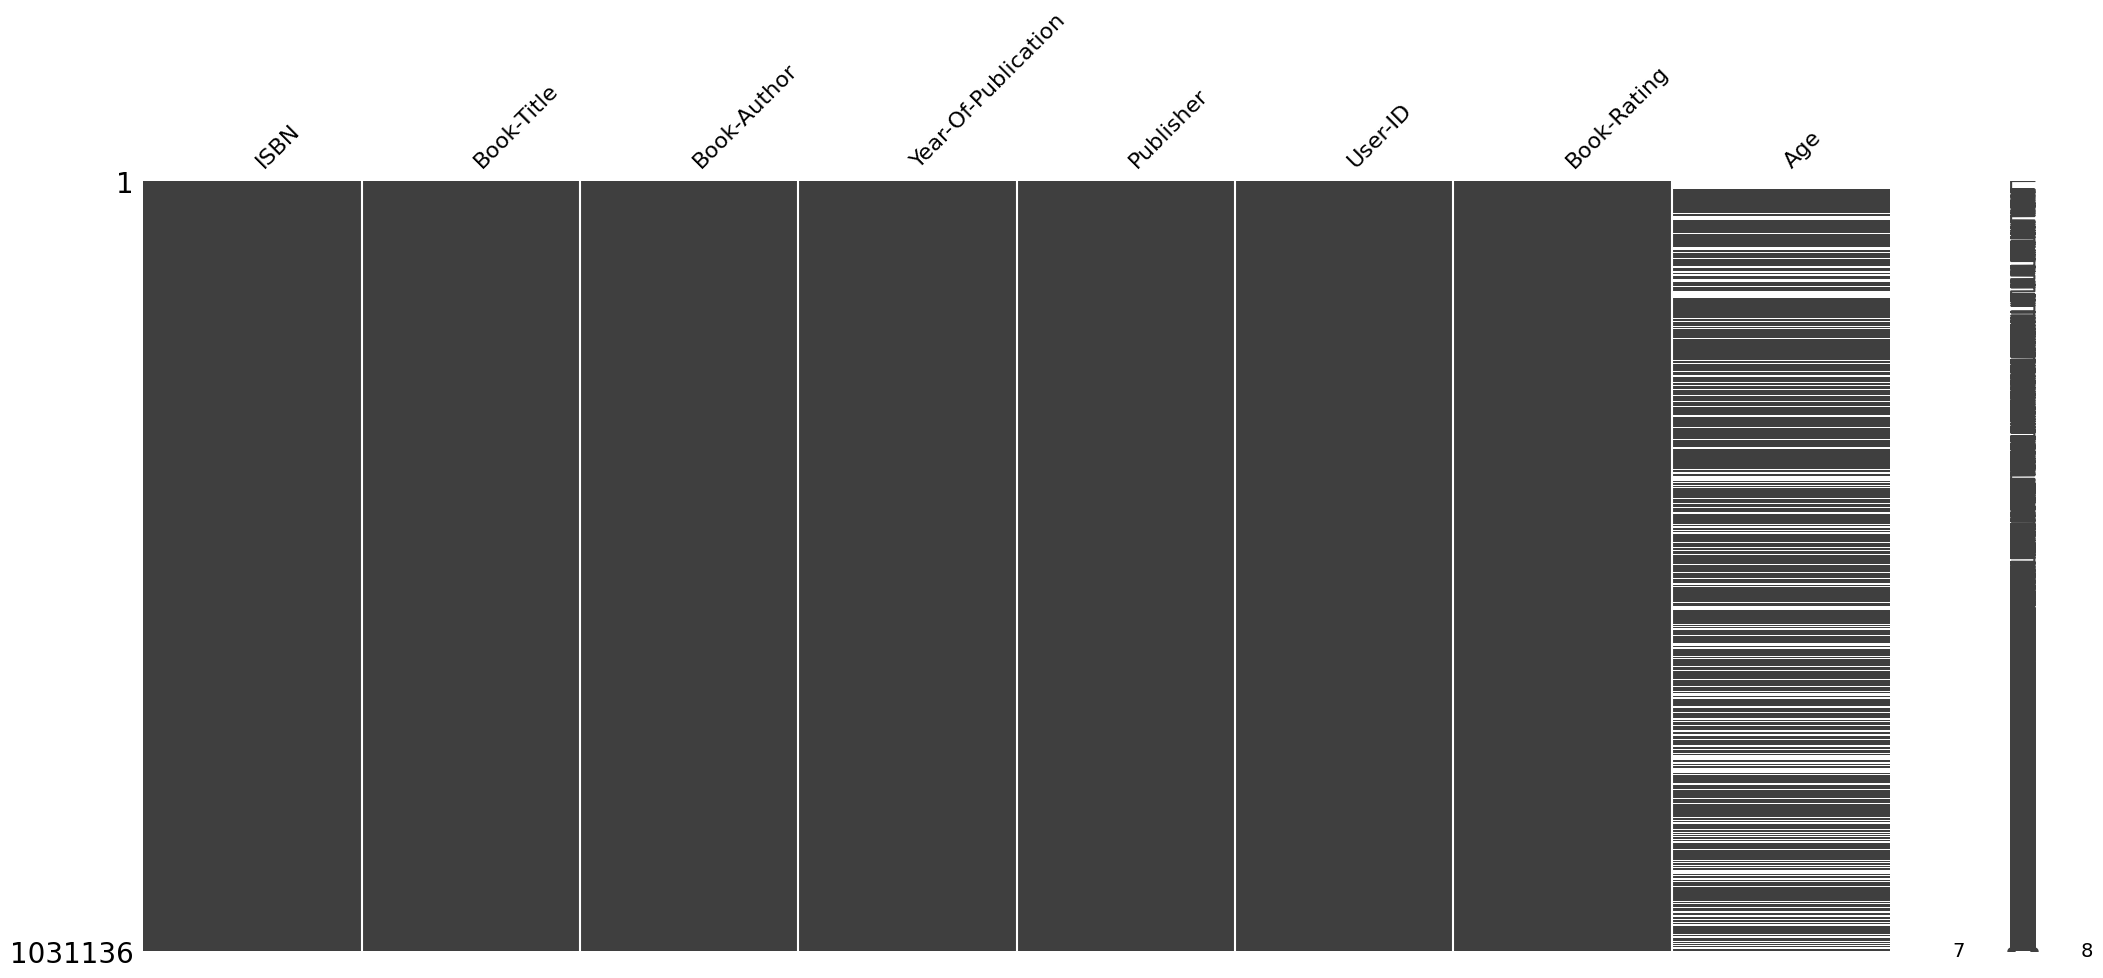

In [9]:
%matplotlib inline
msno.matrix(books)

Предобработка ISBN:




In [10]:
le = LabelEncoder()
le.fit(books["ISBN"].tolist())
books["ISBN"] = le.transform(books["ISBN"])
books.head()

ISBN                                         Book-Title  \
0  24927                                Classical Mythology   
1     73                                       Clara Callan   
2   8175                               Decision in Normandy   
3  59963  Flu: The Story of the Great Influenza Pandemic...   
4  71447                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

   User-ID  Book-Rating   Age  
0        2            0  18.0  
1        8            5   NaN  
2        8            0   NaN  
3        8            0   NaN  
4        8            0   NaN

In [11]:
fig = px.histogram(books.ISBN,
                   x="ISBN",
                   title='Распределение признака ISBN')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

Предобработка Year-Of-Publication:

In [12]:
fig = px.histogram(books['Year-Of-Publication'],
                   x="Year-Of-Publication",
                   title='Распределение признака Year-Of-Publication')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [13]:
books = books[~books['Year-Of-Publication'].isin(['Gallimard', 'DK Publishing Inc'])]
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)
books = books[(books['Year-Of-Publication'] >= 1950) & (books['Year-Of-Publication'] <= 2015)]

In [14]:
fig = px.histogram(books['Year-Of-Publication'],
                   x="Year-Of-Publication",
                   title='Распределение признака Year-Of-Publication')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

Предобработка User-ID:

In [15]:
fig = px.histogram(books['User-ID'],
                   x="User-ID",
                   title='Распределение признака User-ID')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

Предобработка Book-Rating:

In [16]:
fig = px.histogram(books['Book-Rating'],
                   x="Book-Rating",
                   title='Распределение признака Book-Rating')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [17]:
books = books[books['Book-Rating'] > 0]

In [18]:
books.shape

(377721, 8)

Предобработка Age:

In [19]:
books['Age'].isnull().sum()/books.shape[0] * 100

29.780181668480175

In [20]:
fig = px.histogram(books['Age'],
                   x="Age",
                   title='Распределение признака Age')
fig.show()

In [21]:
# попробуем оставить так, потом еще обучим без этих данных
books = books[(books.Age>=13) & (books.Age<=100)]
books["Age"].fillna(round(books["Age"].mean(), 0), inplace = True)

In [22]:
fig = px.histogram(books['Age'],
                   x="Age",
                   title='Распределение признака Age')
fig.show()

Предобработка Location:

In [23]:
# books[['City', 'State', 'Country']] = books.Location.str.split(',', expand=True).iloc[:, 0:3]
# books = books.drop(columns=['Location'])
# rubish_lication = [' n/a', '', ' far away...', ' everywhere and anywhere', ' k1c7b1', ' middlesex', ' ',  ' universe', ' quit',
#                    ' n/a - on the road', ' \\n/a\\"', ' unknown', ]
# usa_location = [' us', ' united states', ' virginia', ' north carolina', ' new york', ' united state', ' florida', ' ca', ' dc', ' california',
#                 ' michigan', ' new jersey', ' texas', ' oregon', ' ca.', ' oklahoma', ' connecticut', ' ua', ' united staes', ' rutherford',
#                 ' tn', ' u.s.a.', ]
# ru_location = ['russia']

# Серьезная предобработка

In [57]:
books_cleaned = books.dropna()

Предобработка Publisher:

In [58]:
f"Всего уникальных издательств {round(books_cleaned['Publisher'].nunique() / books_cleaned.shape[0] * 100, 2)}%"

'Всего уникальных издательств 3.59%'

In [59]:
f"{books_cleaned['Publisher'].nunique()} из {books_cleaned.shape[0]}"

'9420 из 262298'

In [60]:
mean_encoding = books_cleaned.groupby('Publisher')['Book-Rating'].mean()
books_cleaned['Publisher_Mean_Encoding'] = books_cleaned['Publisher'].map(mean_encoding)

In [61]:
fig = px.histogram(books_cleaned['Publisher_Mean_Encoding'],
                   x="Publisher_Mean_Encoding",
                   title='Распределение признака Publisher_Mean_Encoding')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

Предобработка Book-Author:

In [62]:
f"Всего уникальных авторов {round(books_cleaned['Book-Author'].nunique() / books_cleaned.shape[0] * 100, 2)}%"

'Всего уникальных авторов 18.93%'

In [63]:
books_cleaned['Book-Author'].nunique()

49666

In [64]:
label_encoder = LabelEncoder()
books_cleaned['Author_Label'] = label_encoder.fit_transform(books_cleaned['Book-Author'])

In [65]:
fig = px.histogram(books_cleaned['Author_Label'],
                   x="Author_Label",
                   title='Распределение признака Author_Label')
fig.show()

Предобработка Book-Title (используем tf-idf, word2vec, fasttext):

In [66]:
f"Всего уникальных книг {round(books_cleaned['Book-Title'].nunique() / books_cleaned.shape[0] * 100, 2)}%"

'Всего уникальных книг 40.48%'

# word2vec

In [20]:
books_lem = pd.read_csv(way + "lesha.csv")
books_lem.head()

ISBN                                         Book-Title      Book-Author  \
0  169854                            five people meet heaven      Mitch Albom   
1   21918                                            life pi      Yann Martel   
2   32370                      red tent bestselling backlist    Anita Diamant   
3   38820  pilot wife novel tag author weight water oprah...     Anita Shreve   
4  158053                                           good bed  Jennifer Weiner   

   Year-Of-Publication                Publisher  User-ID  Book-Rating   Age  \
0                 2003                 Hyperion    11400            9  49.0   
1                 2002                 Harcourt    11400            6  49.0   
2                 1998              Picador USA    11400            7  49.0   
3                 1999            Little, Brown    11400            7  49.0   
4                 2002  Washington Square Press    11400            8  49.0   

   Publisher_Mean_Encoding  Author_Label  
0                 7.669643         34259  
1                 7.853288         49419  
2                 7.822642          2141  
3                 7.954007          2161  
4                 7.789070         22115

In [22]:
from gensim.models.callbacks import CallbackAny2Vec

class LossLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

def on_epoch_end(self, model):
    print(f'Epoch {self.epoch}')
    self.epoch += 1

In [32]:
w2v_corpus = [str(text).split() for text in books_lem['Book-Title']]
w2v_corpus[:3]

[['five', 'people', 'meet', 'heaven'],
 ['life', 'pi'],
 ['red', 'tent', 'bestselling', 'backlist']]

In [39]:
w2v_model = Word2Vec(window = 10, min_count = 1)
w2v_model.build_vocab(w2v_corpus)
w2v_model.train(
    corpus_iterable=w2v_corpus,
    total_examples=w2v_model.corpus_count,
    epochs=20,
    compute_loss=True,
    callbacks=[LossLogger()]
)

Loss after epoch 0: 1090321.75
Loss after epoch 1: 713778.75
Loss after epoch 2: 571868.5
Loss after epoch 3: 497736.0
Loss after epoch 4: 429126.25
Loss after epoch 5: 383506.0
Loss after epoch 6: 343577.0
Loss after epoch 7: 314700.75
Loss after epoch 8: 309903.0
Loss after epoch 9: 268641.0
Loss after epoch 10: 274048.5
Loss after epoch 11: 252471.0
Loss after epoch 12: 242188.5
Loss after epoch 13: 248913.0
Loss after epoch 14: 258344.5
Loss after epoch 15: 231088.0
Loss after epoch 16: 241221.5
Loss after epoch 17: 237117.5
Loss after epoch 18: 211943.0
Loss after epoch 19: 222438.5


(19848195, 20602060)

# Векторизация fastext

In [117]:
import re
from gensim.models.fasttext import FastText
import spacy
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [93]:
!kaggle datasets download -d ashishjangra27/goodread-books-dataset

 60% 20.0M/33.4M [00:00<00:00, 61.7MB/s]
100% 33.4M/33.4M [00:00<00:00, 86.8MB/s]


In [95]:
!unzip -q goodread-books-dataset.zip

In [99]:
reviews = pd.read_csv("data.csv")
reviews = reviews["desc"]
reviews.sample(5)

76807    When Johnny thinks about Loraine and her touch...
83932    In English history the years between 1714 and ...
41497    Frodo and his Companions of the Ring have been...
64022    The sins of one generation are visited upon an...
37798    (Guitar Recorded Versions). This deluxe songbo...
Name: desc, dtype: object

In [109]:
from gensim.models.callbacks import CallbackAny2Vec

class LossLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

def on_epoch_end(self, model):
    print(f'Epoch {self.epoch}')
    self.epoch += 1

In [127]:
WORD_PATTERN = '(?u)\\b\\w\\w+\\b'
reg_exp = re.compile(pattern=WORD_PATTERN)
sentences = [reg_exp.findall(s.lower()) for s in reviews]

In [129]:
stop_words = set(stopwords.words('english'))

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize(text, num):
    text = ' '.join(text)
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc
                         if token.lemma_ not in stop_words]
    if num % 1000 == 0:
      print(num)
    return lemmatized_tokens

sentences = [lemmatize(s, i) for i, s in enumerate(sentences)]
sentences[:2]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000


[['dinner',
  'sound',
  'three',
  'word',
  'send',
  'reel',
  'bad',
  'straight',
  'near',
  'fast',
  'food',
  'chain',
  'take',
  'joint',
  'relax',
  'dream',
  'dinner',
  'change',
  'forever',
  'new',
  'cookbook',
  'stephanie',
  'allen',
  'tina',
  'kuna',
  'founder',
  'dream',
  'dinner',
  'bring',
  'successful',
  'philosophy',
  'behind',
  'hundred',
  'assemble',
  'freeze',
  'meal',
  'store',
  'across',
  'america',
  'home',
  'kitchen',
  'dream',
  'dinner',
  'offer',
  'one',
  'hundred',
  'recipe',
  'flavorful',
  'meal',
  'make',
  'easy',
  'find',
  'ingredient',
  'premise',
  'scoop',
  'pour',
  'ingredient',
  'bake',
  'pan',
  'plastic',
  'bag',
  'store',
  'uncooked',
  'dish',
  'freezer',
  'later',
  'week',
  'month',
  'dinnertime',
  'roll',
  'around',
  'pop',
  'one',
  'frozen',
  'meal',
  'oven',
  'recipe',
  'provide',
  'two',
  'one',
  'prepare',
  'one',
  'meal',
  'night',
  'two',
  'prepare',
  'enough',
  'thr

In [130]:
ft_model = FastText()
ft_model.build_vocab(sentences)
ft_model.train(
    corpus_iterable=sentences,
    total_examples=ft_model.corpus_count,
    epochs=20,
    compute_loss=True,
    callbacks=[LossLogger()]
)

Loss after epoch 0: 0.0
Loss after epoch 1: 0.0
Loss after epoch 2: 0.0
Loss after epoch 3: 0.0
Loss after epoch 4: 0.0
Loss after epoch 5: 0.0
Loss after epoch 6: 0.0
Loss after epoch 7: 0.0
Loss after epoch 8: 0.0
Loss after epoch 9: 0.0
Loss after epoch 10: 0.0
Loss after epoch 11: 0.0
Loss after epoch 12: 0.0
Loss after epoch 13: 0.0
Loss after epoch 14: 0.0
Loss after epoch 15: 0.0
Loss after epoch 16: 0.0
Loss after epoch 17: 0.0
Loss after epoch 18: 0.0
Loss after epoch 19: 0.0


(121124203, 128204280)

In [137]:
ft_model.save("fasttext_model.model")

# Общие функции

In [1]:
from google.colab import drive
drive.mount('/content/drive')
way = "/content/drive/MyDrive/Colab_Notebooks/python_for_analysis/"

Mounted at /content/drive


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error


import os
import pandas as pd
import warnings
import numpy as np
from sklearn.preprocessing import LabelEncoder
import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

warnings.filterwarnings("ignore")

import xgboost as xgb

import re
from gensim.models.fasttext import FastText
import spacy
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from sklearn.preprocessing import MinMaxScaler

WORD_PATTERN = '(?u)\\b\\w\\w+\\b'

working_columns = ["Age",	"Publisher_Mean_Encoding",	"Author_Label", "Year-Of-Publication", "User-ID"]

In [4]:
books_lem = pd.read_csv(way + "lesha.csv")
books_lem.head()

ISBN                                         Book-Title      Book-Author  \
0  169854                            five people meet heaven      Mitch Albom   
1   21918                                            life pi      Yann Martel   
2   32370                      red tent bestselling backlist    Anita Diamant   
3   38820  pilot wife novel tag author weight water oprah...     Anita Shreve   
4  158053                                           good bed  Jennifer Weiner   

   Year-Of-Publication                Publisher  User-ID  Book-Rating   Age  \
0                 2003                 Hyperion    11400            9  49.0   
1                 2002                 Harcourt    11400            6  49.0   
2                 1998              Picador USA    11400            7  49.0   
3                 1999            Little, Brown    11400            7  49.0   
4                 2002  Washington Square Press    11400            8  49.0   

   Publisher_Mean_Encoding  Author_Label  
0                 7.669643         34259  
1                 7.853288         49419  
2                 7.822642          2141  
3                 7.954007          2161  
4                 7.789070         22115

Пишем проверку моделями:

In [5]:
class ModelTransformer:

    def __init__(self, main_model, word_pattern):

        self.main_model = main_model
        self.word_pattern = word_pattern
        self.re = re.compile(pattern=self.word_pattern)

    def fit(self, X):
        return self

    def transform(self, X):

        X_transformed = np.zeros((len(X), self.main_model.wv.vector_size))
        for i, title in enumerate(X):
            title = str(title)

            title_vector = np.zeros((self.main_model.wv.vector_size,))
            tokens = self.re.findall(title)
            for token in tokens:
                if token in self.main_model.wv.key_to_index:
                    title_vector += self.main_model.wv.get_vector(token)

            X_transformed[i] = title_vector / len(tokens)

        return X_transformed

In [6]:
def model_experiment(books_for_model):
  X = books_for_model.drop("Book-Rating", axis = 1)
  y = books_for_model['Book-Rating']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)


  #logistic regression

  model = LogisticRegression()
  model.fit(X_train, y_train)

  preds = model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, preds))
  print(f'Log Accuracy: {accuracy_score(preds, y_test)}')
  print(f'Log RMSE: {rmse}')


  #linear regression

  model_linear = LinearRegression()
  model_linear.fit(X_train, y_train)

  preds_linear = model_linear.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, preds_linear))
  print(f'Linear MAPE: {mean_absolute_percentage_error(preds_linear, y_test)}')
  print(f'Linear RMSE: {rmse}')


  #xgboost

  dtrain = xgb.DMatrix(X_train, label=y_train)
  dtest = xgb.DMatrix(X_test, label=y_test)

  params = {
    'objective': 'reg:squarederror',  # для задачи линейной регрессии
    'eval_metric': 'rmse',             # используемая метрика (среднеквадратичная ошибка)
    'max_depth': 3,                    # глубина деревьев
    'eta': 0.1,                        # learning rate
    'subsample': 0.8,                  # доля случайных примеров для построения дерева
    'colsample_bytree': 0.8            # доля случайных признаков для построения дерева

  }

  num_round = 100
  model_xgb = xgb.train(params, dtrain, num_round)

  y_pred = model_xgb.predict(dtest)

  print(f'xgb Forest MAE: {mean_absolute_error(y_pred, y_test)}')
  print(f'xgb Forest RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')
  print(f'xgb Forest MAPE: {mean_absolute_percentage_error(y_pred, y_test)}')


  #random forest

  params_forest  = {
    'n_estimators': 60,        # Количество деревьев
    'max_depth': 10,            # Максимальная глубина
    'max_features': 'auto',
    'random_state': 17,
    'n_jobs': -1,              # Количество ядер
    'max_samples': 100000      # Максимум значений в дереве
}


  model_rf = RandomForestRegressor(**params_forest)
  model_rf.fit(X_train, y_train)

  preds_rf = model_rf.predict(X_test)

  rmse_rf = np.sqrt(mean_squared_error(y_test, preds_rf))
  print(f'Random Forest MAPE: {mean_absolute_percentage_error(preds_rf, y_test)}')
  print(f'Random Forest RMSE: {rmse_rf}')

# Бэйзлайн

In [13]:
model_experiment(books_lem[working_columns + ["Book-Rating"]])

Log Accuracy: 0.24308044224170797
Log RMSE: 1.8321378049514845
Linear MAPE: 0.17844721590709342
Linear RMSE: 1.7404533066243968
xgb Forest MAE: 1.3641808095025598
xgb Forest RMSE: 1.7305914519945724
xgb Forest MAPE: 0.1778525706613473
Random Forest MAPE: 0.17671758069287088
Random Forest RMSE: 1.7240120567600539


# С использование Word2Vec

In [40]:
w2v_transformer = ModelTransformer(main_model=ft_model, word_pattern=WORD_PATTERN)
w2v_columns = w2v_transformer.transform(books_lem["Book-Title"].values)
w2v_columns.shape

(262298, 100)

In [41]:
books_w2v = books_lem[working_columns + ["Book-Rating"]].join(pd.DataFrame(w2v_columns))
books_w2v.columns = books_w2v.columns.astype(str)
books_w2v = books_w2v.dropna()
books_w2v.head()

Age  Publisher_Mean_Encoding  Author_Label  Year-Of-Publication  \
0  49.0                 7.669643         34259                 2003   
1  49.0                 7.853288         49419                 2002   
2  49.0                 7.822642          2141                 1998   
3  49.0                 7.954007          2161                 1999   
4  49.0                 7.789070         22115                 2002   

   Book-Rating         0         1         2         3         4  ...  \
0            9  1.188671 -1.244663  1.744028  0.531608 -1.193260  ...   
1            6  1.762306 -0.914676 -0.749331  0.845487 -1.306365  ...   
2            7 -0.393747 -0.932862 -0.216039  1.163949 -0.449914  ...   
3            7  0.661194 -0.043654  1.058267  0.790780 -0.846010  ...   
4            8  0.281168 -4.696026  1.840495  1.078272 -1.816092  ...   

         90        91        92        93        94        95        96  \
0  0.507549  2.064688 -1.034235 -0.526047  1.345963 -2.369055  0.300838   
1  0.509754  0.426544  0.469726  0.017553 -1.026325 -1.116309  0.394875   
2  0.188753  0.233553 -0.487184 -0.285948  0.038121 -0.320024  1.595632   
3  0.815103  1.424175 -0.285601 -0.370901  0.259305 -0.497950  1.064049   
4 -2.304432 -0.671095 -0.581749 -0.507303 -0.149863 -1.577844  4.682471   

         97        98        99  
0  1.690707 -0.880203  1.237972  
1  0.949443  1.381416  1.324768  
2  4.596610 -1.869800  1.118337  
3 -0.299985 -1.151927  0.231187  
4  2.545889 -1.769644  2.828141  

[5 rows x 105 columns]

In [42]:
scaler = MinMaxScaler()
books_w2v_scaled = scaler.fit_transform(books_w2v.drop("Book-Rating", axis = 1))

books_w2v_scaled_df = pd.DataFrame(books_w2v_scaled, columns=books_w2v.drop("Book-Rating", axis=1).columns)

books_w2v_norm = pd.concat([books_w2v_scaled_df, books_w2v["Book-Rating"].reset_index(drop=True)], axis=1)

books_w2v_norm.head()

Age  Publisher_Mean_Encoding  Author_Label  Year-Of-Publication  \
0  0.413793                 0.741071      0.689802             0.883333   
1  0.413793                 0.761476      0.995047             0.866667   
2  0.413793                 0.758071      0.043109             0.800000   
3  0.413793                 0.772667      0.043512             0.816667   
4  0.413793                 0.754341      0.445283             0.866667   

          0         1         2         3         4         5  ...        91  \
0  0.580518  0.488691  0.680754  0.563334  0.382652  0.391235  ...  0.448561   
1  0.616220  0.510457  0.528137  0.579325  0.375336  0.334272  ...  0.368746   
2  0.482032  0.509257  0.560779  0.595550  0.430730  0.459815  ...  0.359343   
3  0.547689  0.567909  0.638779  0.576538  0.405111  0.454670  ...  0.417354   
4  0.524037  0.261042  0.686659  0.591185  0.342368  0.544922  ...  0.315267   

         92        93        94        95        96        97        98  \
0  0.446300  0.453079  0.554085  0.371896  0.478651  0.520761  0.539680   
1  0.548535  0.492564  0.410505  0.442288  0.483965  0.485556  0.681306   
2  0.483487  0.470519  0.474929  0.487031  0.551817  0.658771  0.477710   
3  0.497190  0.464348  0.488316  0.477034  0.521779  0.426216  0.522665   
4  0.477059  0.454441  0.463552  0.416354  0.726248  0.561376  0.483982   

         99  Book-Rating  
0  0.385067            9  
1  0.389449            6  
2  0.379027            7  
3  0.334238            7  
4  0.465350            8  

[5 rows x 105 columns]

In [43]:
model_experiment(books_w2v_norm)

Log Accuracy: 0.2631558877364247
Log RMSE: 1.9980828975309646
Linear MAPE: 0.17883322614567343
Linear RMSE: 1.7413450794362015
xgb Forest MAE: 1.3677118183946086
xgb Forest RMSE: 1.7316773981501115
xgb Forest MAPE: 0.17816477309634696
Random Forest MAPE: 0.17765401549127763
Random Forest RMSE: 1.7304630867926472


# С использованием fasttext

In [14]:
ft_model = FastText.load(way + "fasttext_model.model")

In [16]:
ft_transformer = ModelTransformer(main_model=ft_model, word_pattern=WORD_PATTERN)
ft_columns = ft_transformer.transform(books_lem["Book-Title"].values)
ft_columns.shape

(262298, 100)

In [17]:
books_ft = books_lem[working_columns + ["Book-Rating"]].join(pd.DataFrame(ft_columns))
books_ft.columns = books_ft.columns.astype(str)
books_ft = books_ft.dropna()
books_ft.head()

Age  Publisher_Mean_Encoding  Author_Label  Year-Of-Publication  \
0  49.0                 7.669643         34259                 2003   
1  49.0                 7.853288         49419                 2002   
2  49.0                 7.822642          2141                 1998   
3  49.0                 7.954007          2161                 1999   
4  49.0                 7.789070         22115                 2002   

   Book-Rating         0         1         2         3         4  ...  \
0            9  1.188671 -1.244663  1.744028  0.531608 -1.193260  ...   
1            6  1.762306 -0.914676 -0.749331  0.845487 -1.306365  ...   
2            7 -0.393747 -0.932862 -0.216039  1.163949 -0.449914  ...   
3            7  0.661194 -0.043654  1.058267  0.790780 -0.846010  ...   
4            8  0.281168 -4.696026  1.840495  1.078272 -1.816092  ...   

         90        91        92        93        94        95        96  \
0  0.507549  2.064688 -1.034235 -0.526047  1.345963 -2.369055  0.300838   
1  0.509754  0.426544  0.469726  0.017553 -1.026325 -1.116309  0.394875   
2  0.188753  0.233553 -0.487184 -0.285948  0.038121 -0.320024  1.595632   
3  0.815103  1.424175 -0.285601 -0.370901  0.259305 -0.497950  1.064049   
4 -2.304432 -0.671095 -0.581749 -0.507303 -0.149863 -1.577844  4.682471   

         97        98        99  
0  1.690707 -0.880203  1.237972  
1  0.949443  1.381416  1.324768  
2  4.596610 -1.869800  1.118337  
3 -0.299985 -1.151927  0.231187  
4  2.545889 -1.769644  2.828141  

[5 rows x 105 columns]

In [18]:
scaler = MinMaxScaler()
books_ft_scaled = scaler.fit_transform(books_ft.drop("Book-Rating", axis = 1))

books_ft_scaled_df = pd.DataFrame(books_ft_scaled, columns=books_ft.drop("Book-Rating", axis=1).columns)

books_ft_norm = pd.concat([books_ft_scaled_df, books_ft["Book-Rating"].reset_index(drop=True)], axis=1)

books_ft_norm.head()

Age  Publisher_Mean_Encoding  Author_Label  Year-Of-Publication  \
0  0.413793                 0.741071      0.689802             0.883333   
1  0.413793                 0.761476      0.995047             0.866667   
2  0.413793                 0.758071      0.043109             0.800000   
3  0.413793                 0.772667      0.043512             0.816667   
4  0.413793                 0.754341      0.445283             0.866667   

          0         1         2         3         4         5  ...        91  \
0  0.580518  0.488691  0.680754  0.563334  0.382652  0.391235  ...  0.448561   
1  0.616220  0.510457  0.528137  0.579325  0.375336  0.334272  ...  0.368746   
2  0.482032  0.509257  0.560779  0.595550  0.430730  0.459815  ...  0.359343   
3  0.547689  0.567909  0.638779  0.576538  0.405111  0.454670  ...  0.417354   
4  0.524037  0.261042  0.686659  0.591185  0.342368  0.544922  ...  0.315267   

         92        93        94        95        96        97        98  \
0  0.446300  0.453079  0.554085  0.371896  0.478651  0.520761  0.539680   
1  0.548535  0.492564  0.410505  0.442288  0.483965  0.485556  0.681306   
2  0.483487  0.470519  0.474929  0.487031  0.551817  0.658771  0.477710   
3  0.497190  0.464348  0.488316  0.477034  0.521779  0.426216  0.522665   
4  0.477059  0.454441  0.463552  0.416354  0.726248  0.561376  0.483982   

         99  Book-Rating  
0  0.385067            9  
1  0.389449            6  
2  0.379027            7  
3  0.334238            7  
4  0.465350            8  

[5 rows x 105 columns]

In [19]:
model_experiment(books_ft_norm)

Log Accuracy: 0.2631558877364247
Log RMSE: 1.9980828975309646
Linear MAPE: 0.17883322614567343
Linear RMSE: 1.7413450794362015
xgb Forest MAE: 1.3677118183946086
xgb Forest RMSE: 1.7316773981501115
xgb Forest MAPE: 0.17816477309634696
Random Forest MAPE: 0.17765401549127763
Random Forest RMSE: 1.7304630867926472


# Прдесказания